# How to call text-to-image DIAL applications

This notebook covers how to call text-to-image applications via [DIAL API chat/completions](https://epam-rail.com/dial_api#/paths/~1openai~1deployments~1%7BDeployment%20Name%7D~1chat~1completions/post) call.

**DIAL application** is a general term, which encompasses model adapters and application with custom logic.

DIAL currently supports a few text-to-image model adapters:

* [DALL-E-3](https://github.com/epam/ai-dial-adapter-openai/)
* [Google Imagen](https://github.com/epam/ai-dial-adapter-vertexai/)
* [Stability diffusion](https://github.com/epam/ai-dial-adapter-bedrock/)

These models follow the same pattern of usage - they take a last user message as a prompt for image generation and return the generated image in the response.

As a simple proxy for these models we'll use an application which prints the given user prompt as an image.

## Setup

First, we install the necessary dependencies and import the libraries we will be using.

In [11]:
%pip install -r ../python-notebooks-runner/requirements.txt > /dev/null

Note: you may need to restart the kernel to use updated packages.


In [11]:
import requests
import openai
import langchain_openai

Run docker compose in a separate terminal to start the DIAL Core server locally along with the `image-size` application.

`image-size` is a simple image-to-text application which returns dimensions of an attached image.

```sh
(cd ..; docker compose up core image-size)
```

Let's now configure DIAL Core URL: it will be `http://localhost:8080`, if the DIAL Core is run locally.

In [1]:
import os
dial_url = os.environ.get("DIAL_URL", "http://localhost:8080")
os.environ["DIAL_URL"] = dial_url

Helpers to read images from disk and display images in the notebook:

In [2]:
import base64

from IPython.display import Image as IPImage
from IPython.display import display

def display_base64_image(image_base64):
    image_binary = base64.b64decode(image_base64)
    display(IPImage(data=image_binary))

def read_image_base64(image_path: str) -> str:
    with open(image_path, "rb") as image_file:
        image_base64 = base64.b64encode(image_file.read()).decode()
    return image_base64


## Curl

The application deployment is called `image-size`.

The local DIAL Core server URL is `dial_url`.

The OpenAI API version we are going to use is `2023-03-15-preview`.

Hence the application is accessible via the url:

```
http://${DIAL_URL}/openai/deployments/image-size/chat/completions?api-version=2023-03-15-preview
```

The corresponding curl command with a singe message in the request is:

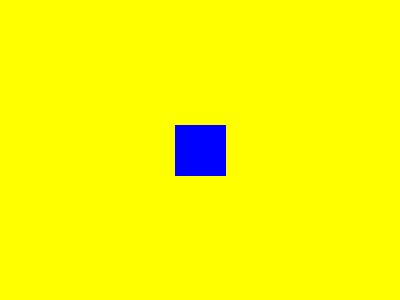

{"choices":[{"index":0,"finish_reason":"stop","message":{"role":"assistant","content":"Size: 400x300px"}}],"usage":null,"id":"410cc421-fe92-4d53-a12d-55dc9a6b67ec","created":1706099578,"object":"chat.completion"}

In [9]:
image_base64 = read_image_base64("./data/images/square.png")
os.environ["IMAGE_BASE64"] = image_base64

display_base64_image(image_base64)

!curl -X POST "${DIAL_URL}/openai/deployments/image-size/chat/completions?api-version=2023-03-15-preview" \
  -H "Api-Key:dial_api_key" \
  -H "Content-Type:application/json" \
  -d '{ "messages": [ { "role": "user", "content": "", "custom_content": { "attachments": [ { "type": "image/png", "data": "'"${IMAGE_BASE64}"'" } ] } } ] }'

## Requests


Let's make an HTTP request from Python using `requests` library and then display the generated image.

The arguments are identical to the curl command above.

Let's call the application in non-streaming mode first:


In [12]:
response = requests.post(
    f"{dial_url}/openai/deployments/image-size/chat/completions?api-version=2023-03-15-preview",
    headers={"Api-Key": "dial_api_key"},
    json={"messages": [{"role": "user", "content": "", "custom_content": {"attachments": [{"type": "image/png", "data": image_base64}]}}]},
)
body = response.json()
display(body)

message = body["choices"][0]["message"]
completion = message["content"]
print(f"Completion: {completion!r}")
assert completion == "Size: 400x300px", "Unexpected completion"

{'choices': [{'index': 0,
   'finish_reason': 'stop',
   'message': {'role': 'assistant', 'content': 'Size: 400x300px'}}],
 'usage': None,
 'id': 'a6e1daab-abc2-455d-8f32-b9cafd7b8c99',
 'created': 1706099669,
 'object': 'chat.completion'}

Completion: 'Size: 400x300px'


When streaming is enabled, the chat completion returns a sequence of messages, each containing a chunk of a generated response:

In [13]:
response = requests.post(
    f"{dial_url}/openai/deployments/image-size/chat/completions?api-version=2023-03-15-preview",
    headers={"Api-Key": "dial_api_key"},
    json={"messages": [{"role": "user", "content": "", "custom_content": {"attachments": [{"type": "image/png", "data": image_base64}]}}], "stream": True},
)
for chunk in response.iter_lines():
    print(chunk)

b'data: {"choices":[{"index":0,"finish_reason":null,"delta":{"role":"assistant"}}],"usage":null,"id":"bcc15e5e-66a1-4e11-bc80-e912dbad66c9","created":1706099696,"object":"chat.completion.chunk"}'
b''
b'data: {"choices":[{"index":0,"finish_reason":null,"delta":{"content":"Size: 400x300px"}}],"usage":null,"id":"bcc15e5e-66a1-4e11-bc80-e912dbad66c9","created":1706099696,"object":"chat.completion.chunk"}'
b''
b'data: {"choices":[{"index":0,"finish_reason":"stop","delta":{}}],"usage":null,"id":"bcc15e5e-66a1-4e11-bc80-e912dbad66c9","created":1706099696,"object":"chat.completion.chunk"}'
b''
b'data: [DONE]'
b''


## OpenAI Python SDK

The DIAL deployment could be called using [OpenAI Python SDK](https://pypi.org/project/openai/) as well.


In [14]:
openai_client = openai.AzureOpenAI(
    azure_endpoint=dial_url,
    azure_deployment="image-size",
    api_key="dial_api_key",
    api_version="2023-03-15-preview",
)

In the non-streaming mode:

In [15]:

chat_completion = openai_client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "",
            "custom_content": {"attachments": [{"type": "image/png", "data": image_base64}]}
        }
    ],
    model="image-size",
)
print(chat_completion)
message = chat_completion.choices[0].message
completion = message.content
print(f"Completion: {completion!r}")
assert completion == "Size: 400x300px", "Unexpected completion"

ChatCompletion(id='7b0af319-75b3-4c37-bc84-69d5574ac27a', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Size: 400x300px', role='assistant', function_call=None, tool_calls=None))], created=1706099744, model=None, object='chat.completion', system_fingerprint=None, usage=None)
Completion: 'Size: 400x300px'


And in the streaming mode:

In [16]:
chat_completion = openai_client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "",
            "custom_content": {"attachments": [{"type": "image/png", "data": image_base64}]}
        }
    ],
    stream=True,
    model="image-size",
)
completion = ""
for chunk in chat_completion:
    print(chunk)
    content = chunk.choices[0].delta.content
    if content:
        completion += content
print(f"Completion: {completion!r}")
assert completion == "Size: 400x300px", "Unexpected completion"

ChatCompletionChunk(id='f847cc25-2a53-405c-a0fa-7b98cbb4a44c', choices=[Choice(delta=ChoiceDelta(content=None, function_call=None, role='assistant', tool_calls=None), finish_reason=None, index=0, logprobs=None)], created=1706099775, model=None, object='chat.completion.chunk', system_fingerprint=None, usage=None)
ChatCompletionChunk(id='f847cc25-2a53-405c-a0fa-7b98cbb4a44c', choices=[Choice(delta=ChoiceDelta(content='Size: 400x300px', function_call=None, role=None, tool_calls=None), finish_reason=None, index=0, logprobs=None)], created=1706099775, model=None, object='chat.completion.chunk', system_fingerprint=None, usage=None)
ChatCompletionChunk(id='f847cc25-2a53-405c-a0fa-7b98cbb4a44c', choices=[Choice(delta=ChoiceDelta(content=None, function_call=None, role=None, tool_calls=None), finish_reason='stop', index=0, logprobs=None)], created=1706099775, model=None, object='chat.completion.chunk', system_fingerprint=None, usage=None)
Completion: 'Size: 400x300px'


## LangChain

The [LangChain](https://pypi.org/project/langchain-openai/) library **is not suitable** as a client of text-to-image applications, since `langchain-openai<=0.0.2` ignores the additional fields attached to the response message.

In [17]:
from langchain_core.messages import HumanMessage

llm = langchain_openai.AzureChatOpenAI(
    azure_endpoint=dial_url,
    azure_deployment="image-size",
    api_key="dial_api_key",
    api_version="2023-03-15-preview",
)

In non-streaming mode:

In [24]:
extra_fields = {"custom_content": {"attachments": [{"type": "image/png", "data": image_base64}]}}

try:
  llm.generate(messages=[[HumanMessage(content="", additional_kwargs=extra_fields)]])

  raise Exception("Generation didn't fail")
except Exception as e:
  assert str(e) == "Error code: 422 - {'error': {'message': 'No image attachment was found in the last message', 'type': 'runtime_error', 'param': None, 'code': None}}", "Unexpected error"

In the streaming mode:

In [25]:

try:
    output = llm.stream(input=[HumanMessage(content="Hello world!", additional_kwargs=extra_fields)])
    for chunk in output:
        print(chunk.dict())

    raise Exception("Generation didn't fail")
except Exception as e:
    assert str(e) == "Error code: 422 - {'error': {'message': 'No image attachment was found in the last message', 'type': 'runtime_error', 'param': None, 'code': None}}", "Unexpected error"
